In [1]:
# single

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 100,
        x_rate = 0.5,
        m_rate = 0.5,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.1,
        grow_factor = 0.1,
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9629629629629629, Loss: 0.3341572019788954
Checkpoint 200, Accuracy: 0.9567901234567902, Loss: 0.30576126663773145
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.27386010134661637
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.2414497799343533
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.2146938995078758


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.82632357 0.01094304 0.16273333]
[1. 0. 0.] <-> [0.9548864  0.0350502  0.01006334]
[0. 1. 0.] <-> [5.6475304e-02 9.4321221e-01 3.1250971e-04]
[1. 0. 0.] <-> [0.9605202  0.0181553  0.02132447]
[0. 0. 1.] <-> [0.22560084 0.04070017 0.73369896]
[0. 0. 1.] <-> [0.08022963 0.00189295 0.9178774 ]
[1. 0. 0.] <-> [0.83266133 0.13825417 0.0290846 ]
[0. 0. 1.] <-> [0.44669235 0.00918711 0.5441205 ]
[1. 0. 0.] <-> [0.90753156 0.01543994 0.07702855]
[1. 0. 0.] <-> [0.8381014  0.14072579 0.02117283]
[1. 0. 0.] <-> [0.9536405  0.01589717 0.03046234]
[1. 0. 0.] <-> [0.9277222  0.02079913 0.05147861]
[0. 0. 1.] <-> [0.08332868 0.00212475 0.91454655]
[1. 0. 0.] <-> [0.8032257  0.16364212 0.03313219]
[1. 0. 0.] <-> [0.95941824 0.01850186 0.02207985]
[1. 0. 0.] <-> [0.85995054 0.01100522 0.12904423]
[0. 0. 1.] <-> [0.13774729 0.00328649 0.8589663 ]
[1. 0. 0.] <-> [0.92086643 0.01974704 0.05938653]
[1. 0. 0.] <-> [0.47940955 0.49469188 0.02589858]
[0. 1. 0.] <-> [0.09049136 0.90845126 0.0

In [12]:
# Testing Performance

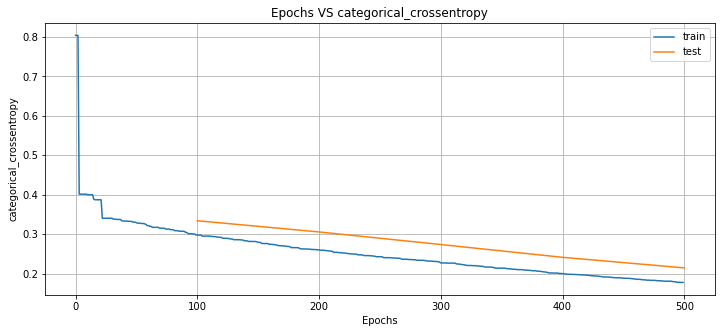

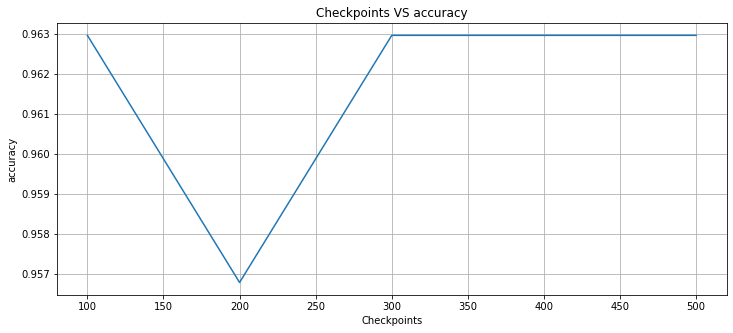

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9629629629629629, 'mean_square_error': 0.1588885507748666, 'categorical_crossentropy': 0.3341572019788954, 'precision': 0.9444444444444444, 'recall': 0.9444444444444444, 'f1': 0.9444444444444444, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 6, 'tn_hit': 22, 'fn_hit': 0}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 4}, 2: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9567901234567902, 'mean_square_error': 0.14335332512162088, 'categorical_crossentropy': 0.30576126663773145, 'precision': 0.9351851851851852, 'recall': 0.9351851851851852, 'f1': 0.9351851851851852, 'essential_metrics': {0: {'tp_hit': 79, 'fp_hit': 6, 'tn_hit': 22, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 4}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.12780040086832162, 'categorical_crossentropy': 0.27386010134661637, 'precisi

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 2.7674396  -1.7851895   0.7327885   2.7431345   0.11236757]
 bias: -2.0860745906829834

Neuron 1: weights:
[-2.2459342   2.649526    1.9054086  -2.3059044   0.20640492]
 bias: -2.415299654006958

Neuron 2: weights:
[ 1.9607925  0.5503293  2.009703  -0.8866938 -1.8594755]
 bias: -1.7156816720962524

Neuron 3: weights:
[ 1.5379667 -2.997203   1.3801688 -2.1733577  1.0714383]
 bias: 0.40622761845588684

$
Layer 2
Neuron 0: weights:
[-3.        -2.3636336  1.1837504  1.2492952]
 bias: 1.0128287076950073

Neuron 1: weights:
[-1.7547836  3.         1.2068777 -1.2382666]
 bias: -1.4905768632888794

Neuron 2: weights:
[ 1.7448279   0.07359798 -2.697588    2.7850678 ]
 bias: -2.823237419128418

$

